## Predicting Airbnb Listing Price | Analysis

This notebook explores feature creation and machine learning modeling to predict the price variable from other features in the data.

In [1]:
import os
import shutil
import warnings
import numpy as np
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [2]:
SEED = 1
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
sns.set_style("white")
cores = mp.cpu_count()

### Feature Engineering

Most of the data being used for modeling is numeric, but the only string feature, the review text, can be turned into an additional numeric feature using natural language processing techniques. I chose to use VADER sentiment analysis to engineer this feature. According to it's [Github page](https://github.com/cjhutto/vaderSentiment), VADER (Valence Aware Dictionary and sEntiment Reasoner) "is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and works well on texts from other domains". After running a string through the Sentiment Intensity Analyzer from the vaderSentiment package, the analyzer returns numeric scores for the positivity, negativity, and neutrality of a sentence.

Before using VADER, I preprocessed the reviews text to remove some extraneous characters such as "\\", "\[", and "\]". For VADER, stopwords and punctuation should be kept in since the classifier incorporates those elements into the analysis.

To use the Sentiment Intensity Analyzer, I wrote my own function called `get_review_sentiment()` that wraps the analyzer in a try-except loop and only returns the positive aspect of the score. Once all sentiment scores were retrieved from review data, I added them to the dataframe as a new column called `pos_score`. Therefore, the review text gets turned into a numeric feature about the positivity of the reviews that a certain listing receives.

For the initial exploration of the creation of `pos_score` and ease of use, I only used the first 1000 rows of the dataset.

In [3]:
directory = '/Users/limesncoconuts2/datasets/airbnb/'
df = pd.read_csv(directory + 'df_clean.csv', nrows=1000)

In [4]:
df.reviews = df.reviews.str.replace("[","").str.replace("]","") \
                    .str.replace("\\","").str.replace("\"","") \
                    .str.replace("\'","").str.replace("rn","").str.strip()

In [5]:
def get_review_sentiment(review, analyzer):
    """Returns the positive sentiment score of a given string
    using a pre-defined VADER sentiment analysis object.
    If string is null, return 0.
    """
    try:
        score = analyzer.polarity_scores(review)
        score = score['pos']
    
    except: # if nan
        score = 0
    
    return score

In [6]:
analyzer = SentimentIntensityAnalyzer()

pool = mp.Pool(cores)
results = [pool.apply(get_review_sentiment, args=(row, analyzer)) for row in df.reviews]
pool.close()    

df['pos_score'] = results

In [7]:
df_sorted = df[['reviews', 'pos_score']].dropna().sort_values(by=['pos_score'], ascending=False)

#### Examples of most and least positive reviews using vaderSentiment:

In [8]:
most_pos = list(df_sorted.head(5).reviews.values)
print("Most positive reviews:")
print("-----------------------")
print("")
for i in most_pos:
    print(i)
    print("")

Most positive reviews:
-----------------------

Great

Perfect 👌🏼

Marcy was great very sweet!

Amazing spectacular experience , highly recommend

Awesome host. Great communication and accommodation skills. Made sure I was taking care of.



In [9]:
least_pos = df_sorted.tail(5).reviews.values
print("Least positive reviews:")
print("-----------------------")
print("")
for i in least_pos:
    print(i)
    print("")

Least positive reviews:
-----------------------

helenaさん。素敵なお家をありがとうございました！nn家族7人が過ごしても広々と使うことができました。キッチンも使いやすく、リビングでのお食事はとても楽しく有意義なものでした。nnまた、洗濯機や乾燥機も使いやすく大変助かりました。nnどんなことにも、親切に対応して下さったhelenaさんに感謝しています。nnまた戻って来たくなる家です。nありがとうございました‼️



Denis非常热情，房间干净舒服，位置非常好，走两条街就是星光大道，门口各种餐厅，有一个挺大的超市，可以自己做早餐，很方便, 房子非常好。尽管二楼房间似乎比较闷热，但中央空调足够将它变得更加凉爽。房间的厨房足够房客烹饪简单的菜肴。房子的地理位置绝佳，公共交通方便，步行也很安全。我们与房东只有一面之缘，但很明显，他非常欢迎我们的到来。下次如果我们还去洛杉矶，这间房子仍是我们的首选。, 房东非常好，我们在那里住的也不错，地理位置很好，旅游的话住这里会节省时间。去环球影城、和好莱坞标志都很近。

这是我们第一次使用Airbnb，也是我第一次在国外过生日！非常完美的体验！Lisa和Jeff非常热情，和我一起庆祝生日，还帮我洗衣服，真是非常感谢他们！房子离威尼斯海滩不远，周围很安静，停车非常方便，并且免费。房间装饰得很温馨，很有家的感觉！总之这次体验非常完美，非常感谢Lisa和Jeff！

房子地理位置很好，旁边就是环球影城，还有很多shopping malls. 因为人多，租了三个房间，所以可以正好一次性拥有整个公寓。最好和房东确认过，租一个房间是否会和别人share房间. 房东很细致，房间里东西也一应俱全。价格也适当。如果家庭出游，真的很方便，推荐！



### Feature Reduction

#### Is VADER data important? 
The negative aspect to using the vaderSentiment package is the very slow speed. For example, 1000 loops of `get_review_sentiment()` takes over 20 minutes, so all 1.1 million data points would take over 10 days to process. Using a random forest regressor and the small dataset for the initial VADER analysis on 1000 rows of data, I analyzed the feature importances to see is `pos_score` would show up.

In [10]:
# random forests for feature selection
X_sent = df.drop(columns=['price_USD', 'reviews'])
y_sent = df.price_USD

X_train, X_test, y_train, y_test = train_test_split(X_sent, y_sent,
                                                    test_size=0.2,
                                                    random_state=SEED)

rf = RandomForestRegressor(n_estimators=500,
                           max_depth=5,
                           n_jobs=-1,
                           random_state=SEED)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

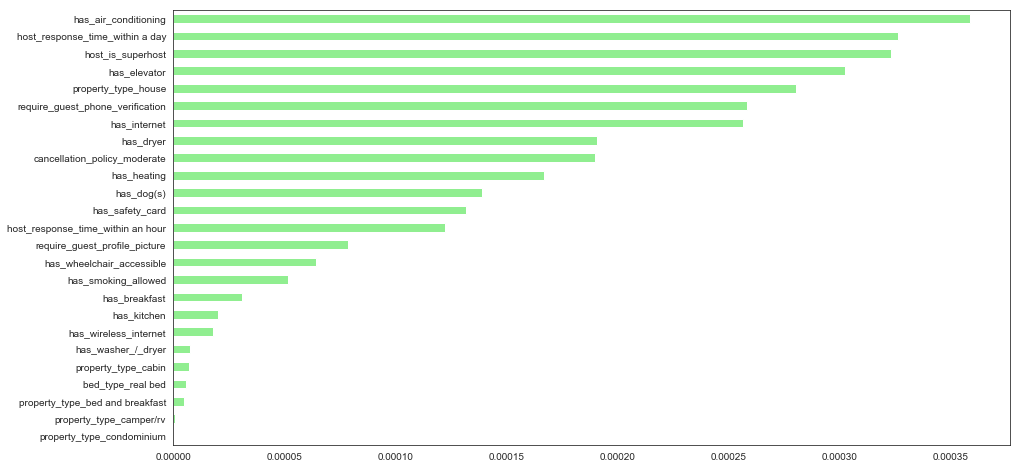

In [11]:
importances_rf = pd.Series(rf.feature_importances_, index = X_sent.columns)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf = sorted_importances_rf[sorted_importances_rf > 0]

fig, ax = plt.subplots(figsize=(15,8))

sorted_importances_rf[:25].plot(kind='barh', color='lightgreen')
plt.show()

In [12]:
'pos_score' in list(sorted_importances_rf[:25].index)

False

Although `pos_score` did not show up in the top 25 features, I ended up deciding to still include the feature in my final modeling given the very small sample size of 1000 data points for this feature analysis. Since the dataset is already large and vaderSentiment analyses are very slow given my hardware constraints, I decided to only work with 50,000 rows of the dataset for the final modeling process.

#### Which Features to Keep?
Even though there will only be one-twentieth of the data in the final modeling process, I still used larger subsets of the data to narrow down the dataset to its most important features. With all features present and with all 1.1 million rows, the dataset was larger than my computer's RAM would allow. Using 500,000 rows of the original clean dataset, I used another random forest regressor to narrow down the 50 most important features that I would then keep for the final modeling process. I kept a list of these column names in a variable called `important_cols`.

In [13]:
df = pd.read_csv(directory + 'df_clean.csv', nrows=500000)

In [14]:
# random forests for feature selection
X_feat = df.drop(columns=['price_USD', 'reviews'])
y_feat = df.price_USD

X_train, X_test, y_train, y_test = train_test_split(X_feat, y_feat, 
                                                    test_size=0.2,random_state=SEED)

rf = RandomForestRegressor(n_estimators=500,
                           max_depth=5,
                           n_jobs=-1,
                           random_state=SEED)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [15]:
y_pred = rf.predict(X_test)

rmse_test = mean_squared_error(y_test, y_pred)**(1/2)
rmse_test

75.36293542584507

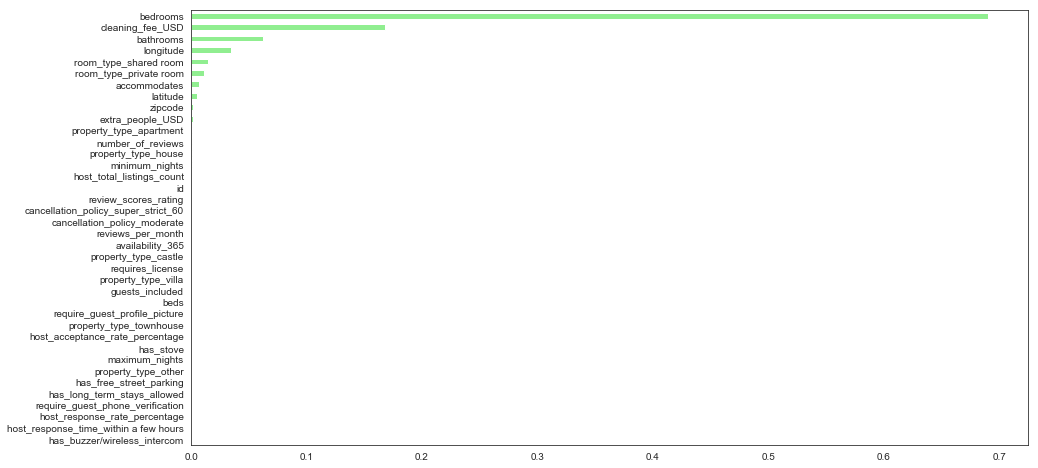

In [16]:
importances_rf = pd.Series(rf.feature_importances_, index = X_feat.columns)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf = sorted_importances_rf[sorted_importances_rf > 0]

fig, ax = plt.subplots(figsize=(15,8))

sorted_importances_rf[:50].plot(kind='barh', color='lightgreen')
plt.show()

In [17]:
important_cols = list(sorted_importances_rf[:50].index) + ['price_USD', 'reviews']

### Modeling
Like previously mentioned, I only used one-twentieth of the dataset and the columns that I previously identified as the most important for creating my model. While not ideal, it allows me to experiment with different methods within the time constraints of this project and the hardware constraints of my computer.

I ran the VADER feature engineering process to create the `pos_score` column for this particular dataset, and then saved the dataframe as a csv file on my computer called `df_ml.csv`. Then I dropped the `reviews` and `price_USD` columns to create my inputs to the model, and identified `price_USD` as the target of my model. After splitting the data into training and testing sets, I trained three different tree-based machine learning models, random forest, stochastic gradient boosting, and XGBoost, and used the root mean squared error to determine which model performed the best. 

Tree-based ensemble models are ideal for this type of analysis, which uses a complex dataset with dozens of features and complex interactions between all of them. Trees allow for the flexibility to fit a model to the specific non-linear trends in the dataset without setting the degree of nonlinearity ahead of time. Ensemble models allow for the combination of several weak tree models to create a model that reduces the variance of the model without compromising too much on bias. Random Forest models are the most simplistic tree-based ensemble model that are built from many aggregated decision trees. The stochastic gradient boosting takes this one step further by improving and building upon iterative models based on their errors, while adding variation from choosing a random subsample of the data at each iteration. The use of subsets of data also makes it harder for the model to overfit to the training data. XGBoost takes gradient boosting even further by implementing second-order gradients of the loss function, which provides more information about minimizing the loss function of the model. It also uses advanced regularization which helps the model to generalize better in many cases. For this dataset, stochastic gradient boosting worked best, with the lowest RMSE score of 43.9.

In [18]:
destination = '/Users/limesncoconuts2/datasets/airbnb/'
filename = 'df_ml.csv'

if(not os.path.isfile(destination + filename)): 
    df = pd.read_csv(directory + 'df_clean.csv',
                 nrows=50000,
                 usecols=important_cols)
    
    df.reviews = df.reviews.str.replace("[","").str.replace("]","") \
                    .str.replace("\\","").str.replace("\"","") \
                    .str.replace("\'","").str.replace("rn","").str.strip()
    
    analyzer = SentimentIntensityAnalyzer()
    pool = mp.Pool(cores)
    results = [pool.apply(get_review_sentiment, args=(row, analyzer)) for row in df.reviews]
    pool.close()
    df['pos_score'] = results

    # save df with pos_score column
    current_dir = os.getcwd() + '/' + filename
    df.to_csv(filename, index=False)
    shutil.move(os.path.join(current_dir), os.path.join(destination, filename))

In [19]:
df = pd.read_csv(directory + 'df_ml.csv')

In [20]:
X = df.drop(columns=['reviews', 'price_USD'])
y = df['price_USD']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

#### Random Forest

In [22]:
rf = RandomForestRegressor(n_estimators=800,
                          max_depth=5,
                          n_jobs=-1,
                          random_state=SEED)

In [23]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [24]:
rmse_test = mean_squared_error(y_test, y_pred)**(1/2)
print('Random Forest Root Mean Squared Error:', round(rmse_test, 1))

Random Forest Root Mean Squared Error: 71.9


#### Stochastic Gradient Boosting

In [25]:
gb = GradientBoostingRegressor(n_estimators=800,
                                subsample=0.8,
                                max_depth=5,
                                random_state=SEED)

In [26]:
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

In [27]:
rmse_test = mean_squared_error(y_test, y_pred)**(1/2)
print('Stochastic Gradient Boosting Root Mean Squared Error:', round(rmse_test, 1))

Stochastic Gradient Boosting Root Mean Squared Error: 43.9


#### XGBoost

In [28]:
xg_reg = xgb.XGBRegressor(n_estimators=800,
                          max_depth=5,
                          objective='reg:linear',
                          n_jobs=cores,
                          random_state=SEED)

In [29]:
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)

In [30]:
rmse_test = mean_squared_error(y_test, y_pred)**(1/2)
print('XGBoost Root Mean Squared Error:', round(rmse_test, 1))

XGBoost Root Mean Squared Error: 44.7


### Model Tuning

I used grid search cross validation to optimize the best performing models, which were the stochastic gradient boosting and xgboost models. The grid search validation chooses the best model based on the negative mean squared error metric, which is a measure of how much the predicted value differs from the actual value.

#### Stochastic Gradient Boosting Model Tuning

In [31]:
gb_params = {
    "n_estimators": [500],
    "subsample": [0.7, 1],
    "max_depth": [5, 7, 9],
    "learning_rate": [0.01, 0.1],
    "random_state": [SEED]
}

gb = GradientBoostingRegressor()

In [32]:
gb_grid = GridSearchCV(estimator=gb,
                   param_grid=gb_params,
                   scoring = 'neg_mean_squared_error',
                   cv=5,
                   n_jobs=-1)

In [33]:
gb_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [500], 'subsample': [0.7, 1], 'max_depth': [5, 7, 9], 'learning_rate': [0.01, 0.1], 'random_state': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [34]:
gb_best_hyperparams = gb_grid.best_params_
gb_best_model = gb_grid.best_estimator_
gb_best_score = gb_grid.best_score_
print('Best hyperparameters:\n', gb_best_hyperparams, '\n')
print('RMSE:', round(np.sqrt(np.abs(gb_best_score)), 1))

Best hyperparameters:
 {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500, 'random_state': 1, 'subsample': 0.7} 

RMSE: 46.8


#### XGBoost Model Tuning

In [35]:
xg_params = {
    "n_estimators": [500],
    "objective": ['reg:linear'],
    "subsample": [0.5, 0.8],
    "max_depth": [5, 7],
    "learning_rate": [0.01],
    "colsample_bytree": [0.9, 1],
    "eval_metrics": ['rmse'],
    "n_jobs": [cores],
    "random_state": [SEED]
}

xg = xgb.XGBRegressor(verbose=0)

In [36]:
xg_grid = GridSearchCV(estimator=xg,
                   param_grid=xg_params,
                   scoring = 'neg_mean_squared_error',
                   cv=5,
                   n_jobs=-1,
                   verbose=0)

In [37]:
%%capture
xg_grid.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_test, y_test)])

In [38]:
xg_best_hyperparams = xg_grid.best_params_
xg_best_model = xg_grid.best_estimator_
xg_best_score = xg_grid.best_score_
print('Best hyperparameters:\n', xg_best_hyperparams, '\n')
print('RMSE:', round(np.sqrt(np.abs(xg_best_score)), 1))

Best hyperparameters:
 {'colsample_bytree': 0.9, 'eval_metrics': 'rmse', 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'n_jobs': 4, 'objective': 'reg:linear', 'random_state': 1, 'subsample': 0.8} 

RMSE: 56.4


In [39]:
test = xg_best_model.evals_result()

#### RMSE Boxplots for Training and Validation Datasets
Boxplots showed that the stochastic gradient boosting model resulted in lower error during the cross-validation process than the XGBoost model, although the difference was not very far off, and the test set hasn't yet been evaluated.

In [40]:
xg_results = pd.DataFrame.from_dict(xg_grid.cv_results_)

In [41]:
gb_results = pd.DataFrame.from_dict(gb_grid.cv_results_)

In [42]:
gb_train = np.sqrt(np.abs(gb_results.mean_train_score))
gb_test = np.sqrt(np.abs(gb_results.mean_test_score))
xg_train = np.sqrt(np.abs(xg_results.mean_train_score))
xg_test = np.sqrt(np.abs(xg_results.mean_test_score))

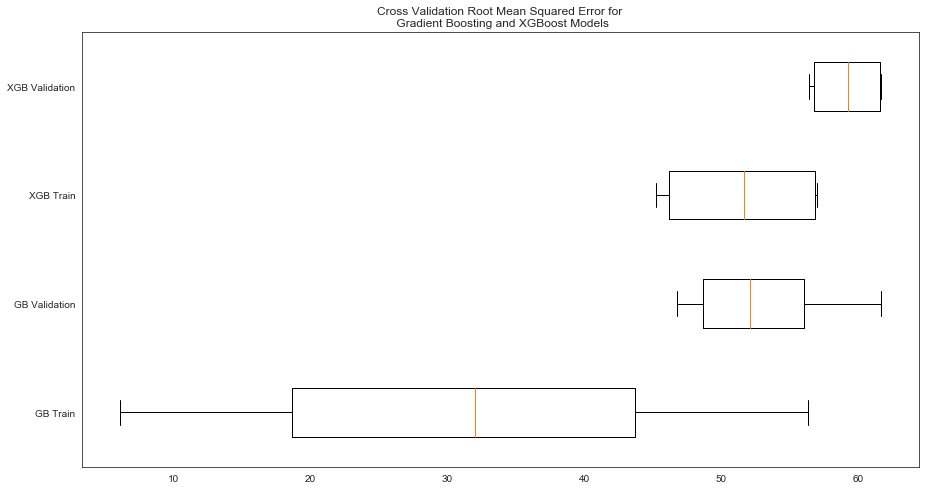

In [43]:
fig, ax = plt.subplots(figsize=(15, 8))
plt_data = [gb_train, gb_test, xg_train, xg_test]
labels = ['GB Train', 'GB Validation', 'XGB Train', 'XGB Validation']
plt.boxplot(plt_data, vert=0)
plt.yticks(np.arange(len(labels))+1, labels)
plt.title("Cross Validation Root Mean Squared Error for \n Gradient Boosting and XGBoost Models")
plt.show()

### Running Models on the Test Dataset:

The initial modeling process used cross-validation to evaluate the ability of the models to generalize to data they haven't seen before, but it uses data that the models actually have seen in the process. A better test, however, is to use the test dataset, which is data that the model has not seen at any stage in the analysis.

The plots for deviance for the stochastic gradient boosting and xgboost models show the differences in error between the entire training set and the held-out test set, while the plots for feature importance show which features of the dataset were most important to the model.

As expected, the results for the training set for both models has less error overall than the results for the test set, with stochastic gradient boostings having less overall error. Additionally, there is significant overlap in the two model's most important features, which is evidence that the inputs to the models are likely to be reproducible between different types of models with varying parameters.

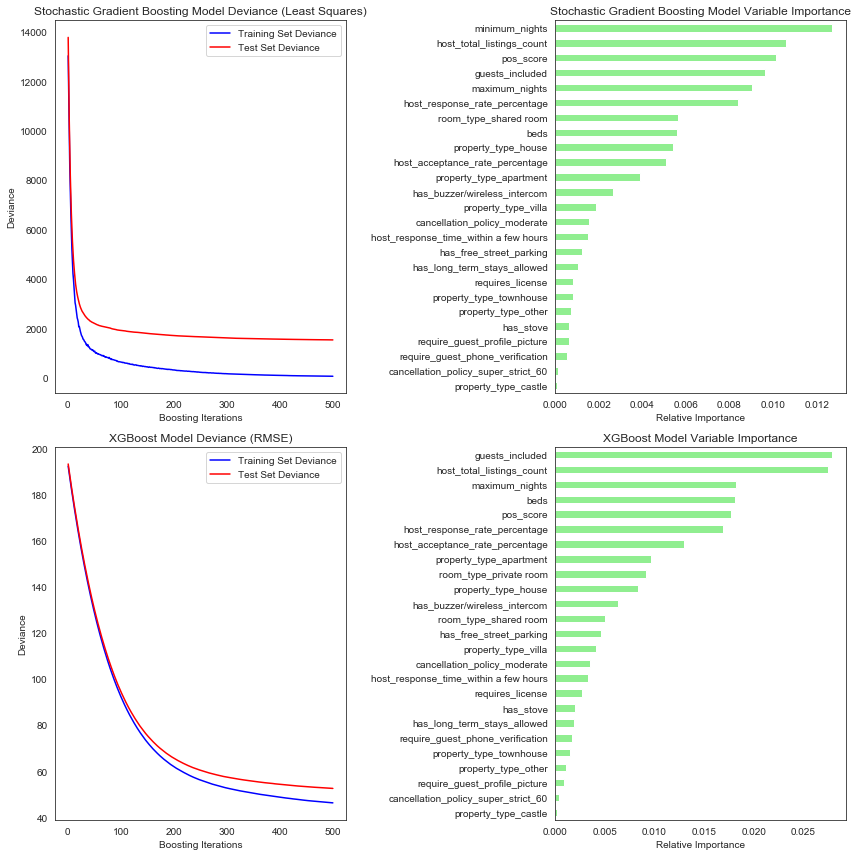

In [44]:
################ STOCHASTIC GRADIENT BOOSTING ######################
# deviances
test_score = np.zeros((500,), dtype=np.float64)
for i, y_pred in enumerate(gb_best_model.staged_predict(X_test)):
    test_score[i] = gb_best_model.loss_(y_test, y_pred)

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.title('Stochastic Gradient Boosting Model Deviance (Least Squares)')
plt.plot(np.arange(500) + 1, gb_best_model.train_score_, 'b-', label='Training Set Deviance')
plt.plot(np.arange(500) + 1, test_score, 'r-', label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# feature importances
importances = pd.Series(gb_best_model.feature_importances_, index = X.columns)
sorted_importances = importances.sort_values()
sorted_importances = sorted_importances[sorted_importances > 0]

plt.subplot(2, 2, 2)
sorted_importances[:25].plot(kind='barh', color='lightgreen')
plt.xlabel('Relative Importance')
plt.title('Stochastic Gradient Boosting Model Variable Importance')

################ XGBOOST ######################
# deviances
train_score = np.zeros((500,), dtype=np.float64)
test_score = np.zeros((500,), dtype=np.float64)

xg_evals = xg_best_model.evals_result()
scores = []

for i in xg_evals.keys():
    scores.append(xg_evals[i]['rmse'])
train_scores = scores[0]
test_scores = scores[1]
test_score = xg_evals[i]['rmse']
    
plt.subplot(2, 2, 3)
plt.title('XGBoost Model Deviance (RMSE)')
plt.plot(np.arange(500) + 1, train_scores, 'b-', label='Training Set Deviance')
plt.plot(np.arange(500) + 1, test_scores, 'r-', label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# feature importances
importances_xg = pd.Series(xg_best_model.feature_importances_, index = X.columns)
sorted_importances_xg = importances_xg.sort_values()
sorted_importances_xg = sorted_importances_xg[sorted_importances_xg > 0]

plt.subplot(2, 2, 4)
sorted_importances_xg[:25].plot(kind='barh', color='lightgreen')
plt.xlabel('Relative Importance')
plt.title('XGBoost Model Variable Importance')

plt.tight_layout()
plt.show()

#### Predicted Price vs. Actual Price

Comparing the predicted prices to their actual values communicates the strength of our model in a more understandable way. The scatter plots show this relationship for every point in the test set. For both models, there is a visible positive trend, which is evidence that the models are often predicting prices close to their actual values.

In [45]:
gb_predictions = gb_best_model.predict(X_test)
xg_predictions = xg_best_model.predict(X_test)

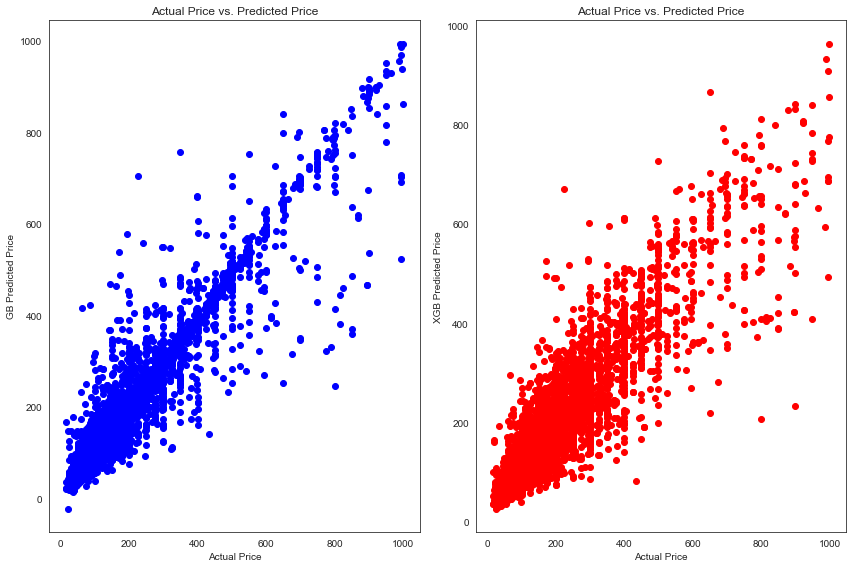

In [46]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.scatter(y_test, gb_predictions, color='blue')
plt.xlabel("Actual Price")
plt.ylabel("GB Predicted Price")
plt.title("Actual Price vs. Predicted Price")

plt.subplot(1, 2, 2)
plt.scatter(y_test, xg_predictions, color='red')
plt.xlabel("Actual Price")
plt.ylabel("XGB Predicted Price")
plt.title("Actual Price vs. Predicted Price")

plt.tight_layout()
plt.show()

#### Price Percent Change

To bring this analysis further, I calculated the percent change between the actual prices and their predicted values. For the stochastic gradient boosting model, more than 60% of price predictions are within 10% of their actual prices, while that number drops to about 30% for the xgboost model. In this sense, we see that the stochastic gradient boosting is much better for getting predictions that closer to their actuals than the xgboost model.

In [47]:
gb_pct_chng = ((gb_predictions - y_test) / y_test)*100
gb_pct_chng = np.abs(round(gb_pct_chng, 2))
gb_frac = len(gb_pct_chng[gb_pct_chng < 10]) / len(gb_pct_chng)
print('Stochastic Gradient Boosting Model:')
print('{0:.1f}% price predictions are within 10% of actual prices. \n'.format(gb_frac*100))

xg_pct_chng = ((xg_predictions - y_test) / y_test)*100
xg_pct_chng = np.abs(round(xg_pct_chng, 2))
xg_frac = len(xg_pct_chng[xg_pct_chng < 10]) / len(xg_pct_chng)
print('XGBoost Model:')      
print('{0:.1f}% price predictions are within 10% of actual prices.'.format(xg_frac*100))

Stochastic Gradient Boosting Model:
61.4% price predictions are within 10% of actual prices. 

XGBoost Model:
32.5% price predictions are within 10% of actual prices.


### Conclusions & Next Steps

The stochastic gradient boosting model for price prediction offers the opportunity for a company like Airbnb to increase their number of listings and be more transparent with its users. There are several uses for a model such as this, including:
1. For those looking to add listings, Airbnb can provide an estimate for how much a host can charge for their listing based on the most important features in the predictive model. For example, the potential host can input how many people they can accommodate, the amenities available, and the room type to get a range of appropriate price points, which could be calculated using the prediction and a confidence interval. This can help with encouraging people to follow-through with posting listings, or for forecasting the financial success of a listing.


2. The model can be implemented in marketing tactics to approach potential hosts with targeted advertising along the lines of "Have an extra private bedroom in Manhattan? You can make X dollars per month by putting your room on Airbnb!". In that way, Airbnb will amass more users and listings.


3. For existing listings, Airbnb can use the model to suggest improvements for hosts to easily increase the value of their listing(s). For example, one insight might be "Hosts that respond to messages within one hour increase the value of their listing by 10%" or "Add a buzzer or wireless intercom to your listing and charge \$10 more per night". Hosts will likely appreciate suggestions for how to easy improve their listings and make more money. And as a result, Airbnb will increase its revenue too.

It's important to note that this model was only trained on a small sample of fifty thousand data points, but there are millions of other rows of data on which to train the model. In fact, adding more training data is probably one of the strongest ways to increase the accuracy of the model. A model with stronger predictive power will only increase the benefits that this model can bring.

#### Future Improvements

In order for the model to work best for the client, the most obvious next step would be to make it production ready. If given more time, I would implement a pipeline in which the data could be read directly into the program, automatically cleaned and processed for feature creation, and run through the machine learning model. This would allow for the client to use my model without having to go through all of the laborious steps themselves.

Looking more inside the model, for the VADER sentiment analysis I would do more preprocessing of the review data to remove non-English reviews to have a cleaner analysis that doesn't numerically de-value non-English entries. I would also like to include more string features into the dataset using VADER, like the listing description or rules data. Additionally, it would also be interesting to see what other NLP methods could be applied to the text data using a package like word2vec or doc2vec.

To make this analysis stronger, I would train these models on the entire Los Angeles dataset, and then to other cities represented in the entire Inside Airbnb dataset. The infrastructure for scaling this model has already been incorporated through the use of functions, but further generalization using object-oriented programming principles could make for an even stronger model. I would also spend more time tuning the model using Randomized Search or the more thorough Grid Search method.